In [1]:
from edc import check_compatibility
check_compatibility("user-2021.12", dependencies=[])

## xcube-gen and xcube-geodb Hands-On Workshop &Phi;-Week 2020
### Alicja Balfanz and Helge Dzierzon from Brockmann Consult

In this Notebook we present how to:
* Access data via xcube-sh with a short excursion to the xcube Generator User Interface
* Use xcube-geodb

##  1) Data access via xcube-sh

Please Note!

The following example shows the use of xcube and xcube Generator User Interface by accissing Sentinel-2 data from SentinelHub. However, SentinelHub is not the only available source! 
Currently there are three Datastores accessible: 
* Climate Data Store 
* SENTINEL Hub  
* ESA CCI Open Data Portal

__Step 1__: Import packages for xcube-sh 

In [2]:
# xcube_sh imports
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig

# various utilities
import json
import xarray as xr
import shapely.geometry
import IPython.display
import zarr

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

%matplotlib inline

__Step 2__: Setting CubeConfig parameters for generating S2 cubes

In [3]:
dataset_name = 'S2L2A' # dataset name
band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B08', 'SCL', 'CLD'] # band names
tile_size = [500, 500] # tile size 
# geometry (bounding box for the area covering Hamburg)
x1 = 9.86
y1 = 53.45
x2 = 10.14
y2 = 53.62
bbox = x1, y1, x2, y2
spatial_res = 0.00018 # spatial resolution (approx. 20 m in degree)
time_tolerance='2H'

A description about the dataset and the bands may be found here: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/ .

__Step 3:__ Setting cube configurations for 2018 summer season (May - August)

In [4]:
cube_config_2018 = CubeConfig(dataset_name = dataset_name,
                              band_names = band_names,
                              tile_size = tile_size, 
                              bbox = bbox,
                              spatial_res = spatial_res,
                              time_range = ['2018-05-01', '2018-08-31'],
                              time_tolerance = time_tolerance)

__Step 4:__ View bounding box to check seleceted area

In [5]:
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

__Step 5:__ Open data cube

In [6]:
cube_S2_2018 = open_cube(cube_config_2018)
cube_S2_2018

<xarray.Dataset>
Dimensions:    (time: 48, lat: 1000, lon: 2000, bnds: 2)
Coordinates:
  * lat        (lat) float64 53.63 53.63 53.63 53.63 ... 53.45 53.45 53.45 53.45
  * lon        (lon) float64 9.86 9.86 9.86 9.861 ... 10.22 10.22 10.22 10.22
  * time       (time) datetime64[ns] 2018-05-03T10:42:09 ... 2018-08-28T10:30:13
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(48, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B01        (time, lat, lon) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    B02        (time, lat, lon) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    B08        (time, lat, lon) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    CLD        (time, lat, lon) uint8 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    SCL        (time, lat, lon) uint8 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S2L2A Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2021-12-14T12:37:39.285984
    time_coverage_start:     2018-05-03T10:42:09+00:00
    time_coverage_end:       2018-08-28T10:30:13+00:00
    time_coverage_duration:  P116DT23H48M4S
    geospatial_lon_min:      9.86
    geospatial_lat_min:      53.45
    geospatial_lon_max:      10.219999999999999
    geospatial_lat_max:      53.63
    processing_level:        L2A

__Step 6:__ Plot a single scene for a specific timestamp and band

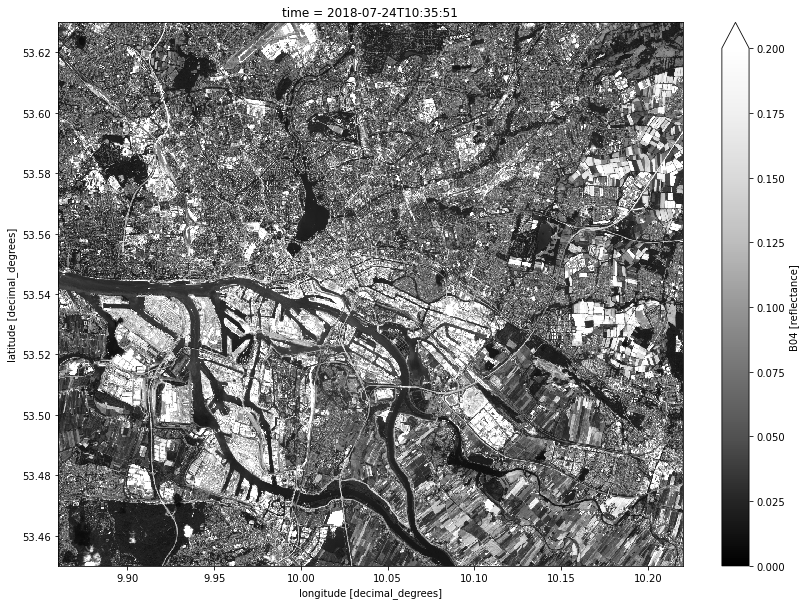

In [7]:
cube_S2_2018.B04.sel(time='2018-07-25 12:00:00', method='nearest').plot.imshow(vmin=0, vmax=0.2, cmap='Greys_r', figsize=(14, 10))

__Step 7:__ Plot a timeseries for a certain location

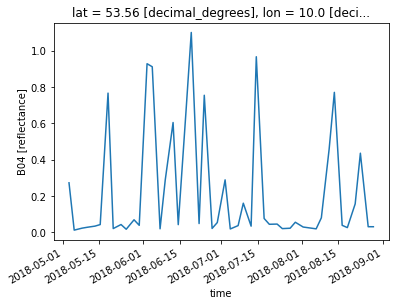

In [8]:
cube_S2_2018.B04.sel(lat=53.56, lon=10.00, method='nearest').plot()

If one wants a subest, e.g. because the region of interest is smaler, this can be achieved by using xcube python api: 

In [9]:
# xcube imports
from xcube.core.compute import compute_cube
from xcube.core.maskset import MaskSet
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.geom import clip_dataset_by_geometry

There are two ways of selecting the area of interest:
* By masking - this keeps only the data of the WKT Polygon or shapefile
* By clipping - this creates a new bounding box, which ensures that the area of interest is within the subset but keeps the surrounding data (*this is commented out in the following cells*)

In [10]:
# Great tool to quickly generate WKT Polygons: https://arthur-e.github.io/Wicket/sandbox-gmaps3.html
polygon = "POLYGON((9.994461289534694 53.580963332925194,10.0002977763511 53.57280950628081,9.995147935042507 53.5625130540729,9.987766495833522 53.55374380185022,9.993946305403835 53.55088830422569,10.002529374251491 53.5553754282651,10.016605607161647 53.56190130476089,10.018493882308132 53.568528117753054,10.00853752244485 53.57535774603685,10.016090623030788 53.578211592240635,10.013000718245632 53.579740359179034,10.00682090867532 53.579230776342285,10.003387681136257 53.58249200035297,9.994461289534694 53.580963332925194))"

In [11]:
cube_S2_2018_masked = mask_dataset_by_geometry(cube_S2_2018, geometry=polygon)
# cube_S2_2018_clipped = clip_dataset_by_geometry(cube_S2_2018, geometry=polygon)

In [12]:
cube_S2_2018_masked
# cube_S2_2018_clipped

<xarray.Dataset>
Dimensions:    (lat: 177, lon: 172, time: 48, bnds: 2)
Coordinates:
  * lat        (lat) float64 53.58 53.58 53.58 53.58 ... 53.55 53.55 53.55 53.55
  * lon        (lon) float64 9.988 9.988 9.988 9.988 ... 10.02 10.02 10.02 10.02
  * time       (time) datetime64[ns] 2018-05-03T10:42:09 ... 2018-08-28T10:30:13
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(48, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B01        (time, lat, lon) float32 dask.array<chunksize=(1, 177, 172), meta=np.ndarray>
    B02        (time, lat, lon) float32 dask.array<chunksize=(1, 177, 172), meta=np.ndarray>
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 177, 172), meta=np.ndarray>
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 177, 172), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 177, 172), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 177, 172), meta=np.ndarray>
    B08        (time, lat, lon) float32 dask.array<chunksize=(1, 177, 172), meta=np.ndarray>
    CLD        (time, lat, lon) float64 dask.array<chunksize=(1, 177, 172), meta=np.ndarray>
    SCL        (time, lat, lon) float64 dask.array<chunksize=(1, 177, 172), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                CF-1.7
    title:                      S2L2A Data Cube Subset
    history:                    [{'program': 'xcube_sh.chunkstore.SentinelHub...
    date_created:               2021-12-14T12:37:39.285984
    time_coverage_start:        2018-05-03T10:42:09+00:00
    time_coverage_end:          2018-08-28T10:30:13+00:00
    ...                         ...
    processing_level:           L2A
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.00018000000000000017
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.00018000000000000844
    date_modified:              2021-12-14T12:38:15.114529

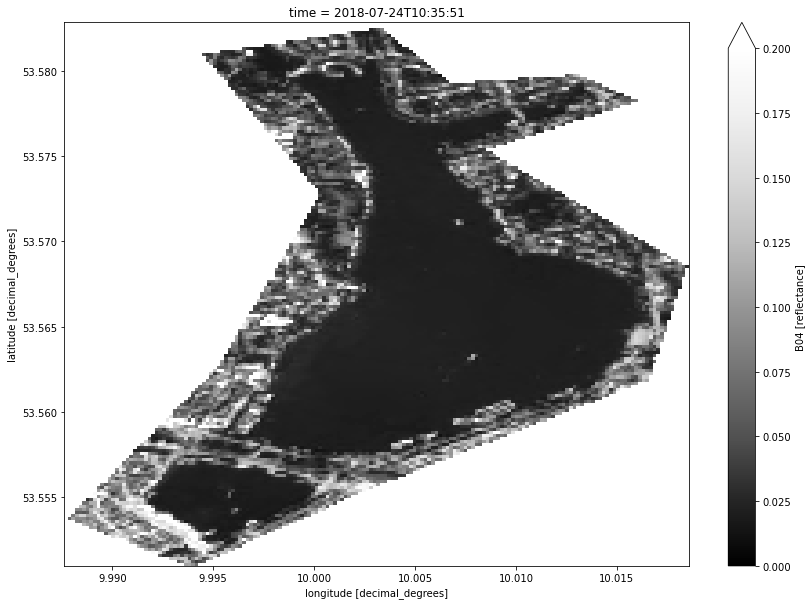

In [13]:
cube_S2_2018_masked.B04.sel(time='2018-07-25 12:00:00', method='nearest').plot.imshow(vmin=0, vmax=0.2, cmap='Greys_r', figsize=(14, 10))
# cube_S2_2018_clipped.B04.sel(time='2018-07-25 12:00:00', method='nearest').plot.imshow(vmin=0, vmax=0.2, cmap='Greys_r', figsize=(14, 10))

Save cube as zarr:

In [14]:
# cube_S2_2018_masked.to_zarr('Alster_cube_2018_masked.zarr')
# cube_S2_2018_clipped.to_zarr('Alster_cube_2018.zarr')

## How to generate a datacube with the help of xcube Generator user interface

__This section is not hands-on!__

If you want to check out the xcube Generator yourself later, please take a look at the [xcube Generator User Guide](https://eurodatacube.com/documentation/xcube-gen-ui-guide) to give you more detail. 

__Open a cube from s3 bucket:__  
The below cell shows how to open a generated datacube which is stored in a public bucket with the help of xcube 

In [15]:
from xcube.core.dsio import open_cube
cube = open_cube('https://s3.eu-central-1.amazonaws.com/edc-phi-week-2020/xcube-gen-1b11e7c1-94f9-4246-833e-a2a12d301a3e.zarr', 
                 s3_kwargs={
                     'anon': True
                 })

In [16]:
cube

<xarray.Dataset>
Dimensions:    (time: 31, lat: 463, lon: 824, bnds: 2)
Coordinates:
  * lat        (lat) float64 53.78 53.77 53.77 53.77 ... 53.32 53.32 53.31 53.31
  * lon        (lon) float64 9.592 9.593 9.594 9.595 ... 10.41 10.41 10.41 10.41
  * time       (time) datetime64[ns] 2018-07-01T12:00:00 ... 2018-07-31T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 463, 824), meta=np.ndarray>
    SCL        (time, lat, lon) uint8 dask.array<chunksize=(1, 463, 824), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    date_created:              2020-09-30T07:08:42.412099
    geospatial_lat_max:        53.77637357203123
    geospatial_lat_min:        53.31337357203123
    geospatial_lon_max:        10.415064453125002
    geospatial_lon_min:        9.591064453125002
    ...                        ...
    processing_level:          L2A
    time_coverage_duration:    P31DT0H0M0S
    time_coverage_end:         2018-08-01T00:00:00+00:00
    time_coverage_resolution:  P1DT0H0M0S
    time_coverage_start:       2018-07-01T00:00:00+00:00
    title:                     S2L2A Data Cube Subset

__Open a cube stored loccaly, here in the workspace:__

In [17]:
#cube = xr.open_zarr('Alster_cube_2018.zarr')

Discover, which flags are available within the datacube:

In [18]:
mask = MaskSet(cube.SCL)
mask

Flag name,Mask,Value
no_data,None,0
saturated_or_defective,None,1
dark_area_pixels,None,2
cloud_shadows,None,3
vegetation,None,4
bare_soils,None,5
water,None,6
clouds_low_probability_or_unclassified,None,7
clouds_medium_probability,None,8
clouds_high_probability,None,9


In [19]:
mask.clouds_high_probability

<xarray.DataArray 'clouds_high_probability' (time: 31, lat: 463, lon: 824)>
dask.array<where, shape=(31, 463, 824), dtype=uint8, chunksize=(1, 463, 824), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 53.78 53.77 53.77 53.77 ... 53.32 53.32 53.31 53.31
  * lon      (lon) float64 9.592 9.593 9.594 9.595 ... 10.41 10.41 10.41 10.41
  * time     (time) datetime64[ns] 2018-07-01T12:00:00 ... 2018-07-31T12:00:00

Make a datacube with all clouds masked out:

In [20]:
cube_wo_clouds = cube.where(xr.ufuncs.logical_not(mask.cloud_shadows | mask.snow_or_ice | 
                                                  mask.saturated_or_defective | mask.cirrus | 
                                                  mask.clouds_low_probability_or_unclassified | 
                                                  mask.clouds_medium_probability | mask.clouds_high_probability))

Keep only the waterbodies of the datacube:

In [21]:
cube_water_wo_clouds = cube_wo_clouds.where(mask.water)

If you want to take a look at the water mask, please uncomment the following line: 

In [22]:
# mask.water.sel(time='2018-07-20 12:00:00', method='nearest').plot.imshow(figsize=(14, 10))

Take a look at a time stamp without any masking:

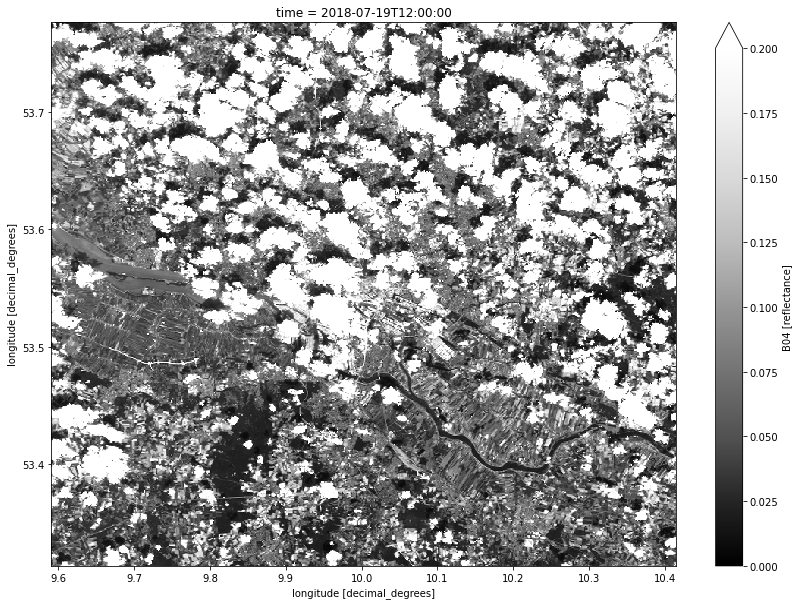

In [23]:
cube.B04.sel(time='2018-07-19 12:00:00', method='nearest').plot.imshow(vmin=0, vmax=0.2, cmap='Greys_r', figsize=(14, 10))

Take a look at a time stamp of the waterbodies and all clouds masked out:

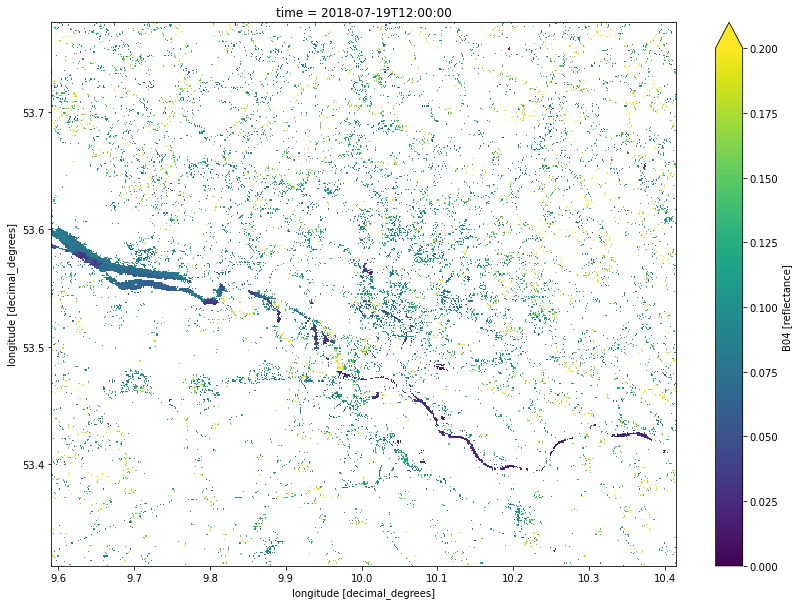

In [24]:
cube_water_wo_clouds.B04.sel(time='2018-07-19 12:00:00', method='nearest').plot.imshow(vmin=0, vmax=.2, figsize=(14, 10))

## 2) Using the xcube-geodb

The xcube-geodb consists of a Restful service and a Python client. Let's import the Python dependencies to access the geodb service.

__Step 1__: Import the geodb client

In [25]:
from xcube_geodb.core.geodb import GeoDBClient

__Step 2__: Instantiate the client

In [26]:
geodb = GeoDBClient()

__Step 3__: As a subscriber a user name is associated with you. Check your user name.

In [27]:
geodb.whoami

'geodb_418dfeac-15f0-4606-9edb-fd9eb722bf04'

__Step 4__: Let's see what collections you have access to

In [28]:
ds = geodb.get_my_collections()
ds

,owner,database,collection,table_name
0,geodb_0b01bfcd-2d09-46f8-84e8-cb5720fba14c,geodb_0b01bfcd-2d09-46f8-84e8-cb5720fba14c,delineated_parcels_s,delineated_parcels_s
1,geodb_0b01bfcd-2d09-46f8-84e8-cb5720fba14c,geodb_0b01bfcd-2d09-46f8-84e8-cb5720fba14c,test_batic,test_batic
2,geodb_0d6df427-8c09-41b9-abc9-64ce13a68125,geodb_0d6df427-8c09-41b9-abc9-64ce13a68125,land_use,land_use
3,geodb_0d6df427-8c09-41b9-abc9-64ce13a68125,geodb_0d6df427-8c09-41b9-abc9-64ce13a68125,lpis_aut,lpis_aut
4,geodb_0e5d743f-2134-4561-8946-a073b039176f,geodb_0e5d743f-2134-4561-8946-a073b039176f,ai4eo_bboxes,ai4eo_bboxes
...,...,...,...,...
882,geodb_geodb_ci,geodb_geodb_ci,land_use,land_use
883,geodb_lpis_iacs_admin,lpis_iacs,land_use_slo,land_use_slo
884,geodb_lpis_iacs_admin,lpis_iacs,lpis_aut,lpis_aut
885,geodb_lpis_iacs_admin,lpis_iacs,lpis_slo,lpis_slo


__Step 5__: In the next step you will create a collection. The properties are defined using OGC standards for properties. However, types are given using postgresql types.

In [29]:
geodb.drop_collection("alster")

collections = {
        "alster": 
        {
            "crs": 4326,
            "properties": 
            {
                "date": "date", 
                "chl": "float",
                "chl_min": "float",
                "chl_max": "float",
                "status": "text"
            }
        }
    }


geodb.create_collections(collections)

__Step 6__: Let's check whether the collection has been created

In [30]:
ds = geodb.get_my_collections()
ds

,owner,database,collection,table_name
0,geodb_0b01bfcd-2d09-46f8-84e8-cb5720fba14c,geodb_0b01bfcd-2d09-46f8-84e8-cb5720fba14c,delineated_parcels_s,delineated_parcels_s
1,geodb_0b01bfcd-2d09-46f8-84e8-cb5720fba14c,geodb_0b01bfcd-2d09-46f8-84e8-cb5720fba14c,test_batic,test_batic
2,geodb_0d6df427-8c09-41b9-abc9-64ce13a68125,geodb_0d6df427-8c09-41b9-abc9-64ce13a68125,land_use,land_use
3,geodb_0d6df427-8c09-41b9-abc9-64ce13a68125,geodb_0d6df427-8c09-41b9-abc9-64ce13a68125,lpis_aut,lpis_aut
4,geodb_0e5d743f-2134-4561-8946-a073b039176f,geodb_0e5d743f-2134-4561-8946-a073b039176f,ai4eo_bboxes,ai4eo_bboxes
...,...,...,...,...
882,geodb_geodb_ci,geodb_geodb_ci,land_use,land_use
883,geodb_lpis_iacs_admin,lpis_iacs,land_use_slo,land_use_slo
884,geodb_lpis_iacs_admin,lpis_iacs,lpis_aut,lpis_aut
885,geodb_lpis_iacs_admin,lpis_iacs,lpis_slo,lpis_slo


__Step 7__: No collection is useful without data. We have created a sample dataset for you which you no load from an S3 AWS object store and open it into a GeoDataFrame. The data is obtained from a local water authority (HU).

In [31]:
import geopandas
import pandas
gdf = geopandas.read_file('https://edc-phi-week-2020.s3.eu-central-1.amazonaws.com/hands-on/alster.geojson')
gdf = gdf.where(pandas.notnull(gdf), None)
gdf

,date,chl,status,chl_min,chl_max,geometry
0,2018-01-05T00:00:00,10.79,"I% 34,0",5.50,15.59,POINT (9.88617 53.54041)
1,2018-02-05T00:00:00,9.35,"I% 34,0",5.82,13.66,POINT (9.88617 53.54041)
2,2018-03-05T00:00:00,11.25,"I% 34,0",7.10,15.43,POINT (9.88617 53.54041)
3,2018-04-05T00:00:00,9.59,"I% 37,0",5.24,17.42,POINT (9.88617 53.54041)
4,2018-05-05T00:00:00,18.88,"I% 34,0",11.55,33.88,POINT (9.88617 53.54041)
...,...,...,...,...,...,...
118,2018-08-27T00:00:00,18.43,"I% 34,0",13.32,27.83,POINT (9.88617 53.54041)
119,2018-08-28T00:00:00,19.14,"I% 41,0",12.81,27.03,POINT (9.88617 53.54041)
120,2018-08-29T00:00:00,30.35,"I% 39,0",9.72,63.58,POINT (9.88617 53.54041)
121,2018-08-30T00:00:00,28.01,"I% 34,0",17.63,46.47,POINT (9.88617 53.54041)


In [32]:
gdf=gdf.dropna()

In [33]:
geodb.insert_into_collection('alster', gdf)

Processing rows from 0 to 104


__Step 8__: Load the inserted data from the geoDB

In [34]:
# geodb.get_collection('alster', database='phi_week')

In [35]:
gdf = geodb.get_collection('alster')
gdf['date'] = pandas.to_datetime(gdf['date'])
gdf

,id,created_at,modified_at,geometry,date,chl,chl_min,chl_max,status
0,1,2021-12-14T12:38:46.877111+00:00,None,POINT (9.88617 53.54041),2018-01-05,10.79,5.50,15.59,"I% 34,0"
1,2,2021-12-14T12:38:46.877111+00:00,None,POINT (9.88617 53.54041),2018-02-05,9.35,5.82,13.66,"I% 34,0"
2,3,2021-12-14T12:38:46.877111+00:00,None,POINT (9.88617 53.54041),2018-03-05,11.25,7.10,15.43,"I% 34,0"
3,4,2021-12-14T12:38:46.877111+00:00,None,POINT (9.88617 53.54041),2018-04-05,9.59,5.24,17.42,"I% 37,0"
4,5,2021-12-14T12:38:46.877111+00:00,None,POINT (9.88617 53.54041),2018-05-05,18.88,11.55,33.88,"I% 34,0"
...,...,...,...,...,...,...,...,...,...
99,100,2021-12-14T12:38:46.877111+00:00,None,POINT (9.88617 53.54041),2018-08-27,18.43,13.32,27.83,"I% 34,0"
100,101,2021-12-14T12:38:46.877111+00:00,None,POINT (9.88617 53.54041),2018-08-28,19.14,12.81,27.03,"I% 41,0"
101,102,2021-12-14T12:38:46.877111+00:00,None,POINT (9.88617 53.54041),2018-08-29,30.35,9.72,63.58,"I% 39,0"
102,103,2021-12-14T12:38:46.877111+00:00,None,POINT (9.88617 53.54041),2018-08-30,28.01,17.63,46.47,"I% 34,0"


In [36]:
feat = gdf['geometry'][0]

__Step 9__: Combine data from Sentinel

In [37]:
cube_S2_2018['B3o1'] = cube_S2_2018.B03/ cube_S2_2018.B01
cube_S2_2018['B3o2'] = cube_S2_2018.B03/ cube_S2_2018.B02
cube_S2_2018

<xarray.Dataset>
Dimensions:    (time: 48, lat: 1000, lon: 2000, bnds: 2)
Coordinates:
  * lat        (lat) float64 53.63 53.63 53.63 53.63 ... 53.45 53.45 53.45 53.45
  * lon        (lon) float64 9.86 9.86 9.86 9.861 ... 10.22 10.22 10.22 10.22
  * time       (time) datetime64[ns] 2018-05-03T10:42:09 ... 2018-08-28T10:30:13
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(48, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B01        (time, lat, lon) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    B02        (time, lat, lon) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    B05        (time, lat, lon) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    B06        (time, lat, lon) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    B08        (time, lat, lon) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    CLD        (time, lat, lon) uint8 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    SCL        (time, lat, lon) uint8 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    B3o1       (time, lat, lon) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    B3o2       (time, lat, lon) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                CF-1.7
    title:                      S2L2A Data Cube Subset
    history:                    [{'program': 'xcube_sh.chunkstore.SentinelHub...
    date_created:               2021-12-14T12:37:39.285984
    time_coverage_start:        2018-05-03T10:42:09+00:00
    time_coverage_end:          2018-08-28T10:30:13+00:00
    ...                         ...
    processing_level:           L2A
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.00018000000000000017
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.00018000000000000844
    date_modified:              2021-12-14T12:38:15.114529

In [38]:
cube_S2_2018_point_low = cube_S2_2018.where((cube_S2_2018.B3o1 < 10) & (cube_S2_2018.SCL==6)).sel(lat=feat.y, lon=feat.x, method='nearest')
cube_S2_2018_point_high = cube_S2_2018.where((cube_S2_2018.B3o2 < 10) & (cube_S2_2018.SCL==6)).sel(lat=feat.y, lon=feat.x, method='nearest')

__Step 10__: Group point time series data by date

In [39]:
agg = gdf.query("date >= '2018-05-01' and date <= '2018-09-01'").groupby(['date']).mean()
agg

,id,chl,chl_min,chl_max
date,,,,
2018-05-05,5.0,18.88,11.55,33.88
2018-05-06,31.0,3.06,1.51,6.73
2018-05-08,80.0,19.07,7.40,50.17
2018-05-13,11.0,69.92,45.83,91.92
2018-05-15,12.0,55.27,45.75,67.19
...,...,...,...,...
2018-08-27,100.0,18.43,13.32,27.83
2018-08-28,101.0,19.14,12.81,27.03
2018-08-29,102.0,30.35,9.72,63.58


__Step 11__: Plot result

In [40]:
import matplotlib.pyplot as plt

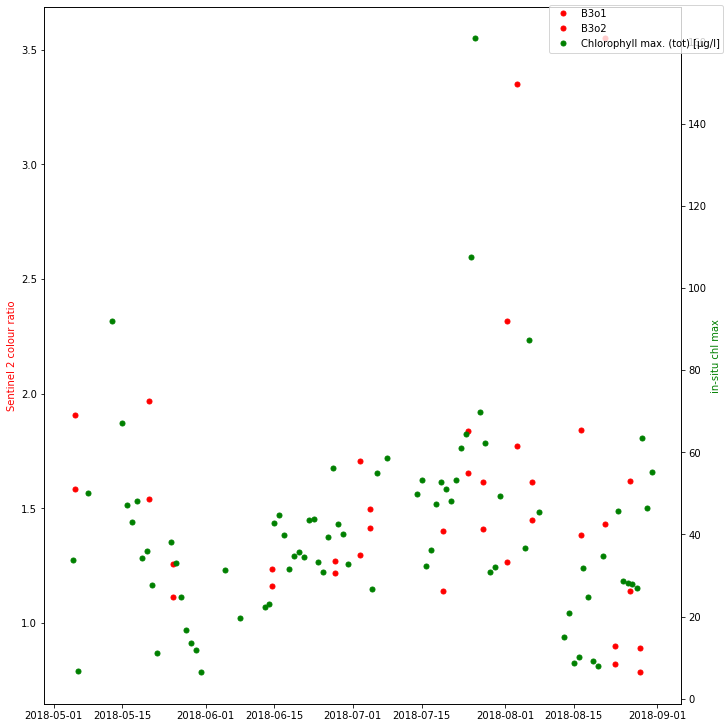

In [41]:
fig, ax1 = plt.subplots(constrained_layout=True, figsize=(10, 10))
ax1.set_ylabel('Sentinel 2 colour ratio', color='red')  
ax1.plot(cube_S2_2018_point_low.time, cube_S2_2018_point_low.B3o1.values, label = "B3o1", color='red', marker='.', linestyle = 'None', markersize=10)
ax1.plot(cube_S2_2018_point_high.time, cube_S2_2018_point_high.B3o2.values, label = "B3o2", color='red', marker='.', linestyle = 'None', markersize=10)

ax2 = ax1.twinx()  
ax2.plot(agg.index, agg.chl_max, label = "Chlorophyll max. (tot) [µg/l]", color='green', marker='.', linestyle = 'None',  markersize=10)
ax2.set_ylabel('in-situ chl max', color='green')  


fig.legend()

